In [1]:
import numpy as np
from itertools import product, permutations
import pickle
import networkx as nx
from random import choice

# Creation of the circuit

We simply take the sequence of Boolean operations and turn it into a graph with NetworkX

In [2]:
from graph.circuit import creation_aes



AES = creation_aes()

# Function for graph display

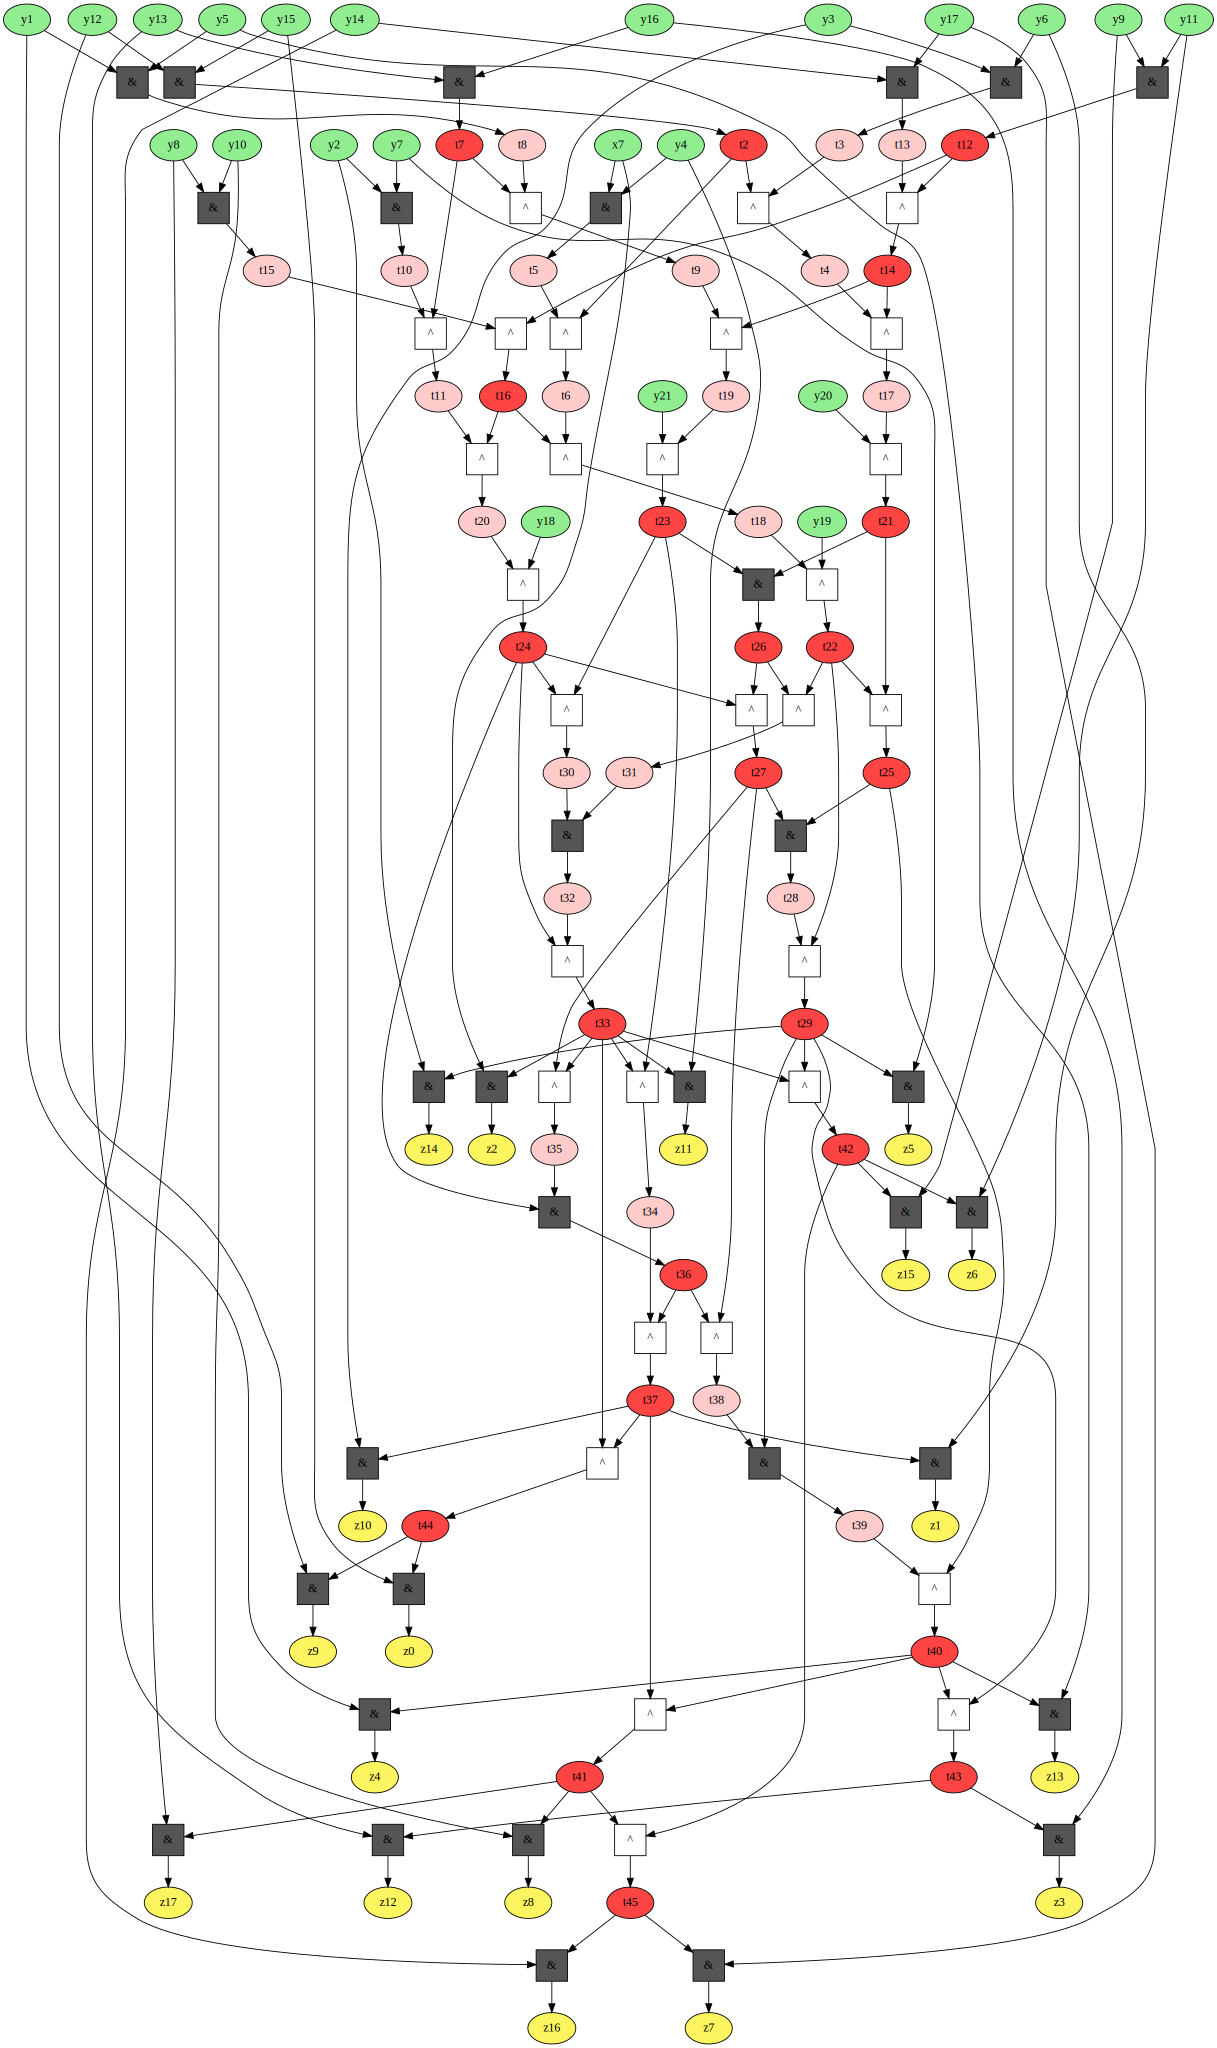

In [3]:
from graph.circuit import plot_circuit


plot_circuit(AES, "aes_full", print=True)


# Regularization
For the moment, regularization has three stages:
- Remove intermediate nodes used only once
- Duplicate inputs used several times
- Gather series of similar operations to create blocks with more than 2 inputs

In [4]:
from graph.regularization import regularize_circuit

AES_REG = regularize_circuit(AES)
plot_circuit(AES_REG, "aes_regularized")

# Construction of subgraphs

Let's import a function allowing to create the subgraph producing a given node.

In [5]:
from graph.circuit import create_subgraph_from_node

## Pre-processing of circuit before the search

Thus pre-processing function returns :
- The list of the leaves (i.e the inputs) of the circuit
- The truth table, which is the list of result. The index of the list correspong to the integer representation of the vector of inputs (following the order of leaves) in big endian
- The symmetries within the graph

In [6]:
from search.utils import int_to_bool_vector
from graph.circuit import find_leaves, evaluation_subtree_from_vec, find_symmetries

def analyze_circuit(tree, root):
    leaves = list(find_leaves(tree))
    l = len(leaves)
    truth_table = []
    for i in range(1 << l):
        inputs = int_to_bool_vector(i, padding=l)
        result = evaluation_subtree_from_vec(tree, inputs, root)
        truth_table.append(result)
    symmetries = find_symmetries(tree)
    return leaves, truth_table, symmetries


# Search of encodings for all compliant subcircuits

The goal here is to compute and to store the solutions of the $p$-encoding search for all the compliant subcircuit.

For the record, a compliant subcircuit
- they have only one output
- they are evaluable with one single bootstrapping
- their output is either a critical node or thean output of the main graph.
- their arity $l$ is lower than the bound $B$
- the PBS is done with a $p < p_{max}$

In [22]:
from search.search import search_aes


def growing_search(root, current_graph, result_container, B, p_min, p_max):

    #phase de vérification qu'on n'a pas déjà traité le noeud
    current_nodes = set(current_graph.nodes)
    for previous_graph in result_container:
        if current_nodes == set(previous_graph.nodes):
            return result_container

    if len(list(find_leaves(current_graph))) > B:
        return result_container
    
    leaves, truth_table, symmetries = analyze_circuit(current_graph, root)
    result = search_aes(leaves, truth_table, symmetries, p_min=p_min, p_max=p_max)
    
    result_container[current_graph] = result
    if result:  #we go deeper
        leaves = [leaf for leaf in find_leaves(current_graph) if current_graph.nodes[leaf]["type"] == "intermediary"]
        for leaf in leaves:
            leaf_name = leaf.split('_')[0]
            next_graph = nx.compose(current_graph, SUBTREES[leaf_name])
            result_container.update(growing_search(root, next_graph, result_container, B, p_min, p_max))
        return result_container
    else:
        return result_container
    


# List of all the nodes that are either an intermediary node or an output
nodes = [key for key, value in nx.get_node_attributes(AES_REG, "type").items() if value == "intermediary"]

# Dict of all the basic subtree generating the former nodes
SUBTREES = {node : create_subgraph_from_node(AES_REG, node, stop_on_intermediary=True) for node in nodes}


#running the search
RESULTS_NEW_ALL = {}
for node, subgraph in SUBTREES.items():
    result = growing_search(node, subgraph, {}, B=9, p_min=7, p_max=23)
    assert type(result) == dict
    RESULTS_NEW_ALL[node] = result


# Searching for valid paths in this mess

Now that we know all the solutions for the valid subgraph, it's time to find chains to evaluate each of the output. We draw random paths and keep the shortest ones.

In [23]:
from random import choice


#Topological order of the nodes in the graph (will be useful later)
TOPO = list(nx.topological_sort(AES_REG))
    
#filter the results to keep only the graphs with a valid solution
RESULTS_NEW = {node : { graph : solution for graph, solution in RESULTS_NEW_ALL[node].items() if solution } for node in RESULTS_NEW_ALL}

# Let us find the most optimal way to evaluate a given output.
def find_random_path_from_output(data, output, result_container):
    subtrees = data[output]
    assert list(subtrees.keys()), f"No possibilities for {output}"
    subtree = choice(list(subtrees.keys()))
    leaves = [x for x in find_leaves(subtree) if subtree.nodes[x]['type'] == 'intermediary']
    result_container[output] = subtree
    for leaf in leaves:
        result_container.update(find_random_path_from_output(data, leaf, result_container))
    return result_container




def sort_path(path_as_dict):
    path_sorted = []
    for node in TOPO:
        if node in path_as_dict:
            path_sorted.append((node, path_as_dict[node]))
    return path_sorted



BEST_PATHS = {}
for i in range(18):
    output = f"z{i}"
    min_l = float("inf")
    for _ in range(1000):
        path = find_random_path_from_output(RESULTS_NEW, output, {})
        l = len(path)
        if l < min_l:
            min_l = l
            best = sort_path(path)
    BEST_PATHS[output] = best


# Transpiling

We write our result in a file that will be parsed by the Rust library

In [24]:

from graph.circuit import evaluation_subtree


def write_path(root, filename):
    path = BEST_PATHS[root]
    f = open(filename, "w")
    for node, tree in path:
        solution, p = RESULTS_NEW[node][tree]
        all_leaves, all_qi, leaves_filtered, qi_filtered = [], [], [], []
        for leaf, qi in solution.items():
            all_leaves.append(leaf)
            all_qi.append(qi)
            if qi:
                leaves_filtered.append(leaf)
                qi_filtered.append(qi)
        truth_table = []
        l = len(leaves_filtered)
        for i in range(1 << l):
            bits = int_to_bool_vector(i, padding=l)
            inputs_formatted = {leaf:b for leaf, b in zip(leaves_filtered, bits)}
            inputs_formatted.update({leaf:0 for leaf in all_leaves if leaf not in leaves_filtered})
            truth_table.append(evaluation_subtree(tree, inputs_formatted, node))
        
        f.write(f"{node};{qi_filtered};{leaves_filtered};{p};{truth_table}\n")
    f.close()

for i in range(18):
    write_path(f'z{i}', f'tests/test_z{i}')
        


# Merging of paths

We merge all the files together so the rust can handle it at once

In [25]:
LINES = {}

for i in range(18):
    f = open(f"tests/test_z{i}", "r")
    for line in f.readlines():
        root = line.split(';')[0]
        if root not in LINES:
            LINES[root] = line
    f.close()


topological_order = [x for x in TOPO if 't' in x or 'z' in x]
LINES_SORTED = {x : LINES[x] for x in topological_order if x in LINES}
print(len(LINES_SORTED))


f = open("tests/total.txt", "w")
for r, line in LINES_SORTED.items():
    f.write(line)
f.close()

37
